In [49]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader,DirectoryLoader
from langchain_astradb import AstraDBVectorStore
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel,Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langgraph.graph import END, StateGraph, START
from langchain import hub
from langchain.schema import Document
from typing import List,Literal
from typing_extensions import TypedDict
from langchain.schema import Document
from pprint import pprint
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
LANGCHAIN_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGCHAIN_PROJECT="Langgraph_bot"
LANGCHAIN_TRACING_V2= True 
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [3]:
llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro",api_key = GOOGLE_API_KEY,temperature = 0.2)
print(llm.invoke("Who are you?").content)

I am a large language model, trained by Google. 

Here's what that means:

* **I am a computer program:** I don't have feelings, experiences, or a physical body.
* **I am trained on a massive amount of text data:** This allows me to communicate and generate human-like text in response to a wide range of prompts. 
* **I can help you with various tasks:** From answering questions to writing stories, translating languages, and summarizing text, I am here to assist you.

How can I help you today? 



**DATA-INGESTION & CONVERSION**

In [4]:
def load_pdf(data):
    loader = DirectoryLoader(path = data,glob = "*.pdf",loader_cls = PyPDFLoader)
    docs = loader.load()
    return docs

extracted_data = load_pdf("data/")

In [5]:
def text_split(extracted_data):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 20)
    text_chunks = text_splitter.split_documents(extracted_data)


    return text_chunks

text_chunks = text_split(extracted_data)
len(text_chunks)

233

In [6]:
load_dotenv()
gemini_embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
ASTRA_DB_API = os.getenv("ASTRA_API_KEY")
ASTRA_ENDPOINT = os.getenv("DB_ENDPOINT")

In [9]:
def ingest(status):
    vector_store = AstraDBVectorStore(token = ASTRA_DB_API,
                                      api_endpoint = ASTRA_ENDPOINT,
                                      embedding = gemini_embeddings,
                                      namespace = "law",
                                      collection_name = "langgraph_RAG")
    is_full = status
    if is_full == None:#THIS MEANS THERE IS NO VECTORS CREATED IN DB
        inserted_ids = vector_store.add_documents(text_chunks)
    else:
        return vector_store
    
    
    return vector_store,inserted_ids

vector_store = ingest(None)#IF YOU ARE RUNNING THIS FOR 2nd TIME CHANGE PARAMETER TO "done"

In [13]:
vector_store = AstraDBVectorStore(token = ASTRA_DB_API,
                                      api_endpoint = ASTRA_ENDPOINT,
                                      embedding = gemini_embeddings,
                                      namespace = "law",
                                      collection_name = "langgraph_RAG")

In [16]:
vector_store = vector_store.as_retriever()

**ROUTING IN THE GRAPH**

In [72]:
from pydantic import BaseModel, Field
from typing import Literal

class Route_Query(BaseModel):
    datasource: Literal["vectorstore", "wiki_search"] = Field(..., description="For a given user question decide whether to route it to vectorstore or wiki_search")

llm_router = llm.with_structured_output(Route_Query)

system = """You are an expert at routing a user question to a vectorstore or wiki_search.
The vectorstore contains documents related to Indian law budget 2024.
Use the vectorstore for questions on these topics. Otherwise, use wiki_search."""

route_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])

question_router = route_prompt | llm_router

print(question_router.invoke({"question": "Tell me about Shrimp Production & Export in budget 2024?"}))

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


[{'args': {'datasource': 'vectorstore'}, 'type': 'Route_Query'}]


In [71]:
data_list = [{'args': {'datasource': 'vectorstore'}, 'type': 'Route_Query'}]

for item in data_list:
    try:
        datasource_value = item['args']['datasource']
        print(datasource_value)
    except KeyError as e:
        print(f"Key error: {e}")

vectorstore


**DOCUMENT GRADER**

In [27]:
class Grade_Docs(BaseModel):
    binary_score : Literal["yes","no"] = Field(...,description = "Documents are relevant to the question, 'yes' or 'no'")

system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages([("system", system),("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),])

llm_grader = llm.with_structured_output(Grade_Docs)

retrieval_grader = grade_prompt | llm_grader
docs = vector_store.get_relevant_documents("Tell me about indian budget 2024")
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": "Tell me about indian budget 2024", "document": doc_txt}))

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
c:\a\envs\main\lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[{'args': {'binary_score': 'yes'}, 'type': 'Grade_Docs'}]


**GENERATION**

In [31]:
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return " ".join(doc.page_content for doc in docs)

question = "Tell me about indian budget 2024"

rag_chain = prompt | llm | StrOutputParser()
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

The Indian Budget for the fiscal year 2024-2025 was presented by Finance Minister Nirmala Sitharaman on July 23, 2024. The budget focuses on nine key priorities, including agriculture, employment, human resource development, manufacturing, urban development, energy security, and infrastructure. It aims to create opportunities for all citizens and contribute to India's development as envisioned in the "Viksit Bharat" initiative. 



**HALLUCINATION-GRADER**

In [32]:
class Grade_Halucinations(BaseModel):
    binary_score: str = Field(...,description = """You are a grader assessing whether an LLM generation is grounded in /
                              supported by a set of retrieved facts. \n
                              Give a binary score 'yes' or 'no'. 
                              'Yes' means that the answer is grounded in / supported by the set of facts.""")
    

hallucination_prompt = ChatPromptTemplate.from_messages([("system", system),("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),])

hallucination_grader = hallucination_prompt | llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

[{'args': {'binary_score': 'yes'}, 'type': 'Grade_Docs'}]

**ANSWER GRADER**

In [34]:
class AnswerGrader(BaseModel):
    binary_score: str = Field(..., description="Does answer resolve query 'Yes' or 'No'.")

llm_ans_grader = llm.with_structured_output(AnswerGrader)
system = """You are a grader assessing whether an answer addresses / resolves a question.
Give a binary score 'yes' or 'no'. 'Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "user question {question} \n generation:{generation}")])

answer_grader = answer_prompt | llm_ans_grader
answer_grader.invoke({"question": question, "generation": generation})

AnswerGrader(binary_score='yes')

**PROMPT RE-WRITER**

In [36]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""


rewrite_prompt = ChatPromptTemplate([("system",system),("human","Here is the initial question:\n{question} formulate only one improved question")])

question_rewriter = rewrite_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the key features and highlights of the Indian Budget for the fiscal year 2024? \n'

**WIKIPEDIA AGENT**

In [39]:
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

wiki.invoke("Who conducted Budget 2024 of india")

'Page: Nirmala Sitharaman\nSummary: Nirmala Sitharaman (born 18 August 1959) is an Indian economist, politician and a senior leader of the Bharatiya Janata Party (BJP) serving as the Minister of Finance'

**GRAPH**

In [40]:
class GraphState(TypedDict):
    question : str
    generation : str
    documents : List[str]

In [52]:
def retrieve(state):
    question = state["question"]
    documents = state["documents"]

    generation = vector_store.invoke({"context":documents})
    return {"documents": documents, "question": question, "generation": generation}

In [53]:
def generate(state):
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [74]:
def grade_documents(state):
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(d.page_content)

        for item in score:
            score_value = item['args']['binary_score']

        if score_value == "yes":#IF THE DOCUMENT IS RELEVANT
            filtered_docs.append(d)
        else:
            continue

    return {"documents":filtered_docs,"question":question}


In [43]:
def transform_query(state):
    question = state["question"]
    documents = state["documents"]

    better_question = question_rewriter.invoke({"question":question})
    return {"documents":documents,"question":better_question}

In [45]:
def wiki_search(state):
    question = state["question"]
    print(question)

    docs = wiki.invoke(question)
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

EDGES

In [73]:
def route_question(state):
    question = state["question"]

    source = question_router.invoke({"question":question})

    for item in source:
        datasource_value = item['args']['datasource']

    if datasource_value == "wiki_search":
        return "wiki_search"
    else:
        return "vectorstore"
    

In [47]:
def decide_to_generate(state):
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        return "transform_query"
    else:
        return "generate"

In [48]:
def grade_generation_v_documents_and_question(state):
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    for item in score:
        grade = item['args']['binary_score']

    if grade == "yes":
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            return "useful"
        else:
            return "not useful"
    else:
        return "not supported"

In [54]:
workflow = StateGraph(GraphState)

workflow.add_node("wiki_search", wiki_search) 
workflow.add_node("retrieve", retrieve)  
workflow.add_node("grade_documents", grade_documents) 
workflow.add_node("generate", generate) 
workflow.add_node("transform_query", transform_query)

In [56]:
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("wiki_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

app = workflow.compile()


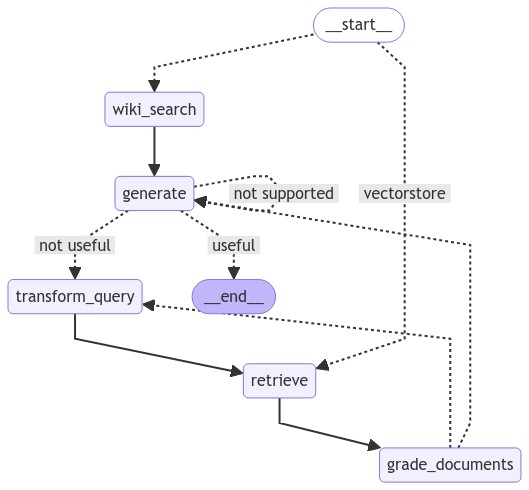

In [58]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [62]:
inputs = {
    "question": "Tell me about Sharukh Khan?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

AttributeError: 'list' object has no attribute 'datasource'

In [63]:
score[0]['args']['binary_score']

NameError: name 'score' is not defined